# <center> <img src="../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> **Big Data** </center>
---
### <center> **Autumn 2025** </center>
---
### <center> **Examples on Structured Streaming (files)** </center>
---
**Profesor**: Pablo Camarillo Ramirez

# Create SparkSession

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Examples on Structured Streaming (files)") \
    .master("spark://spark-master:7077") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")
# Optimization (reduce the number of shuffle partitions)
spark.conf.set("spark.sql.shuffle.partitions", "5")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/07 14:05:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Create a data stream from a local socket

### Install netcat utility

In [2]:
!apt-get update
!apt-get install -y netcat

Get:1 http://archive.ubuntu.com/ubuntu jammy InRelease [270 kB]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [17.5 MB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,275 kB]
Get:7 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [71.0 kB]
Get:8 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [5,712 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy/restricted amd64 Packages [164 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [266 kB]
Get:11 http://archive.ubuntu.com/ubuntu jammy/main amd64 Packages [1,792 kB]   
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3,750 kB]
Get:13 http://security.ubuntu.com/ubun

### Connect Spark to the socket

In [6]:
# Create the remote connection
lines = spark.readStream \
            .format("socket") \
            .option("host", "localhost") \
            .option("port", 9999) \
            .load()
# Perform some transfromtions to the input data (word counter)
from pyspark.sql.functions import explode, split
words = lines.select(explode(split(lines.value, " ")).alias("word"))
word_count = words.groupBy("word").count()

# Send transformed data to the Sink
query = word_count.writeStream \
            .outputMode("complete") \
            .format("console") \
            .start()
query.awaitTermination(300)


-------------------------------------------
Batch: 0
-------------------------------------------
+----+-----+
|word|count|
+----+-----+
+----+-----+

-------------------------------------------
Batch: 1
-------------------------------------------
+----+-----+
|word|count|
+----+-----+
|hola|    1|
+----+-----+

-------------------------------------------
Batch: 2
-------------------------------------------
+------+-----+
|  word|count|
+------+-----+
|    mi|    1|
|nombre|    1|
|    es|    1|
|  hola|    1|
+------+-----+

-------------------------------------------
Batch: 3
-------------------------------------------
+-------+-----+
|   word|count|
+-------+-----+
|carlos!|    1|
|     mi|    1|
| nombre|    1|
|     es|    1|
|   juan|    1|
|   hola|    1|
+-------+-----+

-------------------------------------------
Batch: 4
-------------------------------------------
+-------+-----+
|   word|count|
+-------+-----+
|carlos!|    1|
|     mi|    1|
| nombre|    1|
|     es|    1|
| 

False

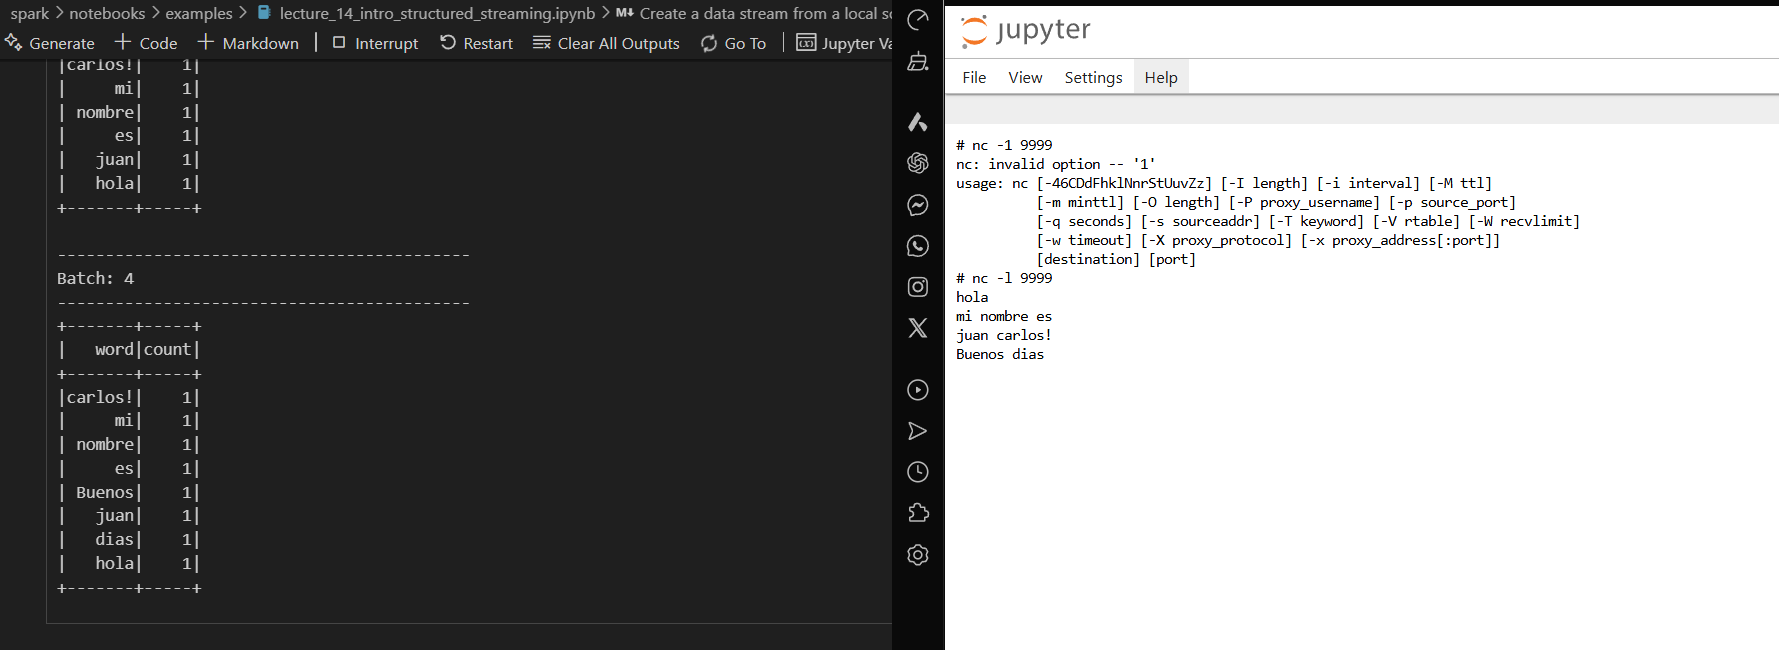

# Create a data stream from files

In [ ]:
!ls data/structured_streaming_names/
!pwd

In [ ]:
from pcamarillor.spark_utils import SparkUtils

names_schema = SparkUtils.generate_schema([("name", "string"), ("gpa", "float")])

names_df = spark.readStream \
            .format("json") \
            .schema(names_schema) \
            .load("/opt/spark/work-dir/data/structured_streaming_names/")

query = names_df.writeStream \
            .outputMode("append") \
            .format("console") \
            .start()

query.awaitTermination(30) # Wait 30 seconds before closing the stream

In [ ]:
sc.stop()